# Rotten Tomatoes Sentiment Analysis
Conducting sentiment analysis (pos/neg) on the Rotten Tomatoes dataset from HuggingFace.

## Setup

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# WordCloud
from wordcloud import WordCloud

# NLTK
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# HuggingFace
import datasets

# Transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report
)

# Progress report
from tqdm.notebook import tqdm

In [ ]:
# Setting seeds
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Load Data

In [2]:
# Load train, validation, and test data
train_data, validation_data, test_data = datasets.load_dataset("rotten_tomatoes",
                                                               split=["train", "validation", "test"])
train_data, validation_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 8530
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1066
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1066
 }))

In [3]:
# Checking data example
train_data[0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1}

In [4]:
# Data features
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [3]:
# Changing train data into df form
train_df = pd.DataFrame(train_data)
train_df.reset_index(inplace=True)
train_df.rename(columns={'index':'id'}, inplace=True)
train_df

,id,text,label
0,0,the rock is destined to be the 21st century's ...,1
1,1,"the gorgeously elaborate continuation of "" the...",1
2,2,effective but too-tepid biopic,1
3,3,if you sometimes like to go to the movies to h...,1
4,4,"emerges as something rare , an issue movie tha...",1
...,...,...,...
8525,8525,any enjoyment will be hinge from a personal th...,0
8526,8526,if legendary shlockmeister ed wood had ever ma...,0
8527,8527,hardly a nuanced portrait of a young woman's b...,0
8528,8528,"interminably bleak , to say nothing of boring .",0


## EDA

Text(0.5, 1.0, 'Distribution between pos/neg reviews')

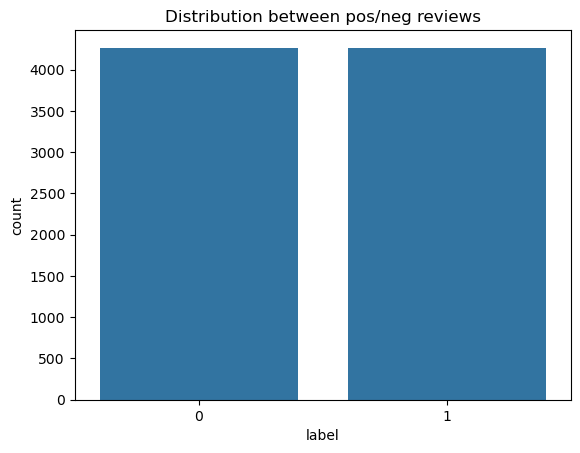

In [6]:
# Distribution between positive and negative reviews
sns.countplot(data=train_df, x='label')
plt.title("Distribution between pos/neg reviews")

We can see that there is an equal distribution between movies that have positive reviews and movies that have negative reviews in the training set.

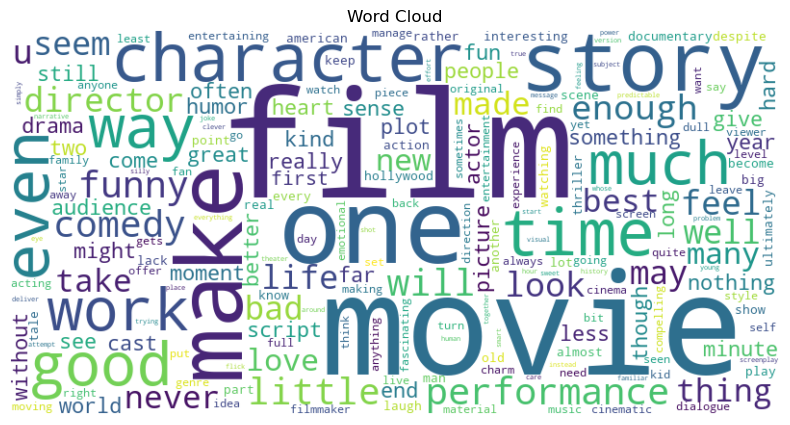

In [5]:
# Combine all text from the single column into one string
text = " ".join(train_df['text'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

## NLTK
We will use the NLTK library to conduct sentiment analysis. Specifically, we will be using the Valence Aware Dictionary and sEntiment Reasoner (VADER).

In [8]:
# Download VADER lexicon
nltk.download('vader_lexicon')

# Create instance of Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Example
sia.polarity_scores("I am so happy!")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Anaqi_Amir/nltk_data...


{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [9]:
# Another example
sia.polarity_scores("I am so sad")

{'neg': 0.629, 'neu': 0.371, 'pos': 0.0, 'compound': -0.5256}

In [9]:
# Applying polarity scores to the entire train_df
results = {}
for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
    text = row['text']
    myid = row['id']
    results[myid] = sia.polarity_scores(text)

  0%|          | 0/8530 [00:00<?, ?it/s]

In [10]:
# Displaying the result in a dataframe format
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(train_df, how='inner', left_on='id', right_on='id')
vaders

,id,neg,neu,pos,compound,text,label
0,0,0.000,0.918,0.082,0.3612,the rock is destined to be the 21st century's ...,1
1,1,0.000,0.758,0.242,0.8069,"the gorgeously elaborate continuation of "" the...",1
2,2,0.000,0.594,0.406,0.2617,effective but too-tepid biopic,1
3,3,0.000,0.633,0.367,0.8271,if you sometimes like to go to the movies to h...,1
4,4,0.086,0.650,0.264,0.6592,"emerges as something rare , an issue movie tha...",1
...,...,...,...,...,...,...,...
8525,8525,0.101,0.786,0.113,0.0644,any enjoyment will be hinge from a personal th...,0
8526,8526,0.052,0.796,0.153,0.4897,if legendary shlockmeister ed wood had ever ma...,0
8527,8527,0.156,0.844,0.000,-0.3400,hardly a nuanced portrait of a young woman's b...,0
8528,8528,0.000,0.754,0.246,0.2411,"interminably bleak , to say nothing of boring .",0


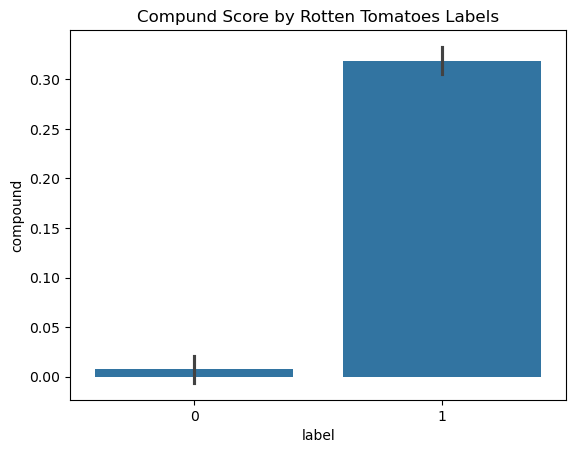

In [11]:
# Visualize the results
ax = sns.barplot(data=vaders, x='label', y='compound')
ax.set_title('Compund Score by Rotten Tomatoes Labels')
plt.show()

The graph indicates that the mean compound score for negative sentiment labels are less than 0.05 while the mean compound score for positive sentiment labels are slightly above 0.3.

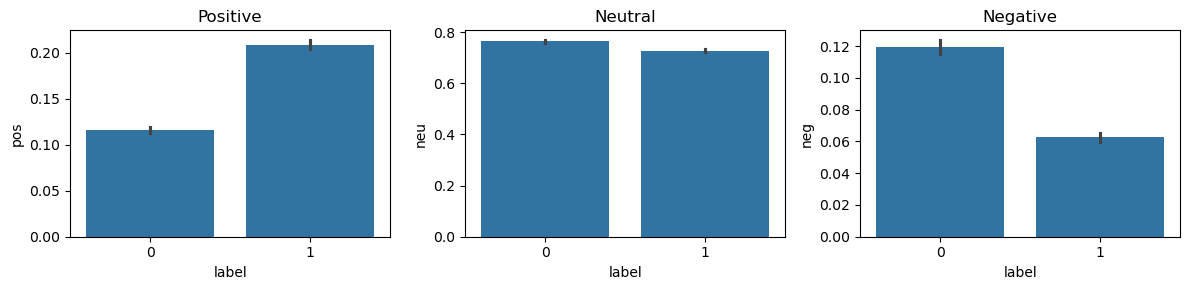

In [15]:
# Visualize results based on different sentiments
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='label', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='label', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='label', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

The graphs above show that the VADER polarity scores are consistent with the labelling of positive and negative movie review sentiments.

In [12]:
# Assigning labels based on VADERS results
vader_labels = {}
for index, row in tqdm(vaders.iterrows(), total=len(vaders)):
    if row['compound'] > 0:
        label = 1
    else:
        label = 0

    vader_labels[index] = label

  0%|          | 0/8530 [00:00<?, ?it/s]

In [13]:
vaders['vader_labels'] = pd.Series(vader_labels)
vaders

,id,neg,neu,pos,compound,text,label,vader_labels
0,0,0.000,0.918,0.082,0.3612,the rock is destined to be the 21st century's ...,1,1
1,1,0.000,0.758,0.242,0.8069,"the gorgeously elaborate continuation of "" the...",1,1
2,2,0.000,0.594,0.406,0.2617,effective but too-tepid biopic,1,1
3,3,0.000,0.633,0.367,0.8271,if you sometimes like to go to the movies to h...,1,1
4,4,0.086,0.650,0.264,0.6592,"emerges as something rare , an issue movie tha...",1,1
...,...,...,...,...,...,...,...,...
8525,8525,0.101,0.786,0.113,0.0644,any enjoyment will be hinge from a personal th...,0,1
8526,8526,0.052,0.796,0.153,0.4897,if legendary shlockmeister ed wood had ever ma...,0,1
8527,8527,0.156,0.844,0.000,-0.3400,hardly a nuanced portrait of a young woman's b...,0,0
8528,8528,0.000,0.754,0.246,0.2411,"interminably bleak , to say nothing of boring .",0,1


In [19]:
# Calculate classification metrics
y_true = vaders['label']
y_pred = vaders['vader_labels']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
print("Classification Report:\n", report)

Accuracy: 0.6348182883939039
Precision: 0.6206968933669186
Recall: 0.6933177022274326
F1 Score: 0.6550005537711817
Confusion Matrix:
[[2458 1807]
 [1308 2957]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.58      0.61      4265
           1       0.62      0.69      0.66      4265

    accuracy                           0.63      8530
   macro avg       0.64      0.63      0.63      8530
weighted avg       0.64      0.63      0.63      8530



As we can see, the VADERS model does not give a satisfactory result.

## ROBERTA

In [20]:
# Setting up ROBERTA model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [21]:
# Function to get polarity scores using Roberta model
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [23]:
train_df

,id,text,label
0,0,the rock is destined to be the 21st century's ...,1
1,1,"the gorgeously elaborate continuation of "" the...",1
2,2,effective but too-tepid biopic,1
3,3,if you sometimes like to go to the movies to h...,1
4,4,"emerges as something rare , an issue movie tha...",1
...,...,...,...
8525,8525,any enjoyment will be hinge from a personal th...,0
8526,8526,if legendary shlockmeister ed wood had ever ma...,0
8527,8527,hardly a nuanced portrait of a young woman's b...,0
8528,8528,"interminably bleak , to say nothing of boring .",0


In [24]:
# Running the model on the entire train_df dataset
res = {}
for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
    try:
        text = row['text']
        myid = row['id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/8530 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [25]:
# Displaying the result in a dataframe format
roberta = pd.DataFrame(res).T
roberta = roberta.reset_index().rename(columns={'index': 'id'})
roberta = roberta.merge(train_df, how='inner', left_on='id', right_on='id')
roberta

,id,roberta_neg,roberta_neu,roberta_pos,text,label
0,0,0.002251,0.078214,0.919535,the rock is destined to be the 21st century's ...,1
1,1,0.024806,0.225588,0.749606,"the gorgeously elaborate continuation of "" the...",1
2,2,0.636203,0.339475,0.024322,effective but too-tepid biopic,1
3,3,0.002743,0.076569,0.920688,if you sometimes like to go to the movies to h...,1
4,4,0.090276,0.525855,0.383869,"emerges as something rare , an issue movie tha...",1
...,...,...,...,...,...,...
8525,8525,0.114693,0.432905,0.452402,any enjoyment will be hinge from a personal th...,0
8526,8526,0.370913,0.561094,0.067993,if legendary shlockmeister ed wood had ever ma...,0
8527,8527,0.264912,0.635329,0.099759,hardly a nuanced portrait of a young woman's b...,0
8528,8528,0.856152,0.125944,0.017904,"interminably bleak , to say nothing of boring .",0


In [27]:
# Assigning labels based on VADERS results
roberta_labels = {}
for index, row in tqdm(roberta.iterrows(), total=len(roberta)):
    if row['roberta_pos'] > row['roberta_neg']:
        label = 1
    else:
        label = 0

    roberta_labels[index] = label

  0%|          | 0/8530 [00:00<?, ?it/s]

In [28]:
roberta['roberta_labels'] = pd.Series(roberta_labels)
roberta

,id,roberta_neg,roberta_neu,roberta_pos,text,label,roberta_labels
0,0,0.002251,0.078214,0.919535,the rock is destined to be the 21st century's ...,1,1
1,1,0.024806,0.225588,0.749606,"the gorgeously elaborate continuation of "" the...",1,1
2,2,0.636203,0.339475,0.024322,effective but too-tepid biopic,1,0
3,3,0.002743,0.076569,0.920688,if you sometimes like to go to the movies to h...,1,1
4,4,0.090276,0.525855,0.383869,"emerges as something rare , an issue movie tha...",1,1
...,...,...,...,...,...,...,...
8525,8525,0.114693,0.432905,0.452402,any enjoyment will be hinge from a personal th...,0,1
8526,8526,0.370913,0.561094,0.067993,if legendary shlockmeister ed wood had ever ma...,0,0
8527,8527,0.264912,0.635329,0.099759,hardly a nuanced portrait of a young woman's b...,0,0
8528,8528,0.856152,0.125944,0.017904,"interminably bleak , to say nothing of boring .",0,0


In [29]:
# Calculate classification metrics
y_true = roberta['label']
y_pred = roberta['roberta_labels']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
print("Classification Report:\n", report)

Accuracy: 0.7941383352872216
Precision: 0.8104429596634496
Recall: 0.7678780773739742
F1 Score: 0.7885865639296894
Confusion Matrix:
[[3499  766]
 [ 990 3275]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80      4265
           1       0.81      0.77      0.79      4265

    accuracy                           0.79      8530
   macro avg       0.79      0.79      0.79      8530
weighted avg       0.79      0.79      0.79      8530



## Tokenizer

In [ ]:
# Create tokenizer from a pre-trained BERT model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Use map function to tokenize entire dataset
train_data = train_data.map(lambda examples: tokenizer(examples["text"], return_tensors = 'np'), batched=True)

# Display example
train_data[0]

In [ ]:
# Data features after tokenizing
train_data.features